In [1]:
import numpy as np
import seaborn as sns
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv

# https://biopython.org/docs/1.74/api/Bio.SVDSuperimposer.html
from Bio.SVDSuperimposer import SVDSuperimposer

from numpy import array, dot, set_printoptions

In [2]:
tetra = md.load('./tetra.pdb')
view = nv.show_mdtraj(tetra.atom_slice(tetra.top.select('chainid 0 1 2 3')))
view

NGLWidget()

In [3]:
"""Bezier, a module for creating Bezier curves.
Version 1.1, from < BezierCurveFunction-v1.ipynb > on 2019-05-02
"""

import numpy as np

__all__ = ["Bezier"]


class Bezier():
    def TwoPoints(t, P1, P2):
        """
        Returns a point between P1 and P2, parametised by t.
        INPUTS:
            t     float/int; a parameterisation.
            P1    numpy array; a point.
            P2    numpy array; a point.
        OUTPUTS:
            Q1    numpy array; a point.
        """

        if not isinstance(P1, np.ndarray) or not isinstance(P2, np.ndarray):
            raise TypeError('Points must be an instance of the numpy.ndarray!')
        if not isinstance(t, (int, float)):
            raise TypeError('Parameter t must be an int or float!')

        Q1 = (1 - t) * P1 + t * P2
        return Q1

    def Points(t, points):
        """
        Returns a list of points interpolated by the Bezier process
        INPUTS:
            t            float/int; a parameterisation.
            points       list of numpy arrays; points.
        OUTPUTS:
            newpoints    list of numpy arrays; points.
        """
        newpoints = []
        #print("points =", points, "\n")
        for i1 in range(0, len(points) - 1):
            #print("i1 =", i1)
            #print("points[i1] =", points[i1])

            newpoints += [Bezier.TwoPoints(t, points[i1], points[i1 + 1])]
            #print("newpoints  =", newpoints, "\n")
        return newpoints

    def Point(t, points):
        """
        Returns a point interpolated by the Bezier process
        INPUTS:
            t            float/int; a parameterisation.
            points       list of numpy arrays; points.
        OUTPUTS:
            newpoint     numpy array; a point.
        """
        newpoints = points
        #print("newpoints = ", newpoints)
        while len(newpoints) > 1:
            newpoints = Bezier.Points(t, newpoints)
            #print("newpoints in loop = ", newpoints)

        #print("newpoints = ", newpoints)
        #print("newpoints[0] = ", newpoints[0])
        return newpoints[0]

    def Curve(t_values, points):
        """
        Returns a point interpolated by the Bezier process
        INPUTS:
            t_values     list of floats/ints; a parameterisation.
            points       list of numpy arrays; points.
        OUTPUTS:
            curve        list of numpy arrays; points.
        """

        if not hasattr(t_values, '__iter__'):
            raise TypeError("`t_values` Must be an iterable of integers or floats, of length greater than 0 .")
        if len(t_values) < 1:
            raise TypeError("`t_values` Must be an iterable of integers or floats, of length greater than 0 .")
        if not isinstance(t_values[0], (int, float)):
            raise TypeError("`t_values` Must be an iterable of integers or floats, of length greater than 0 .")

        curve = np.array([[0.0] * len(points[0])])
        for t in t_values:
            #print("curve                  \n", curve)
            #print("Bezier.Point(t, points) \n", Bezier.Point(t, points))

            curve = np.append(curve, [Bezier.Point(t, points)], axis=0)

            #print("curve after            \n", curve, "\n--- --- --- --- --- --- ")
        curve = np.delete(curve, 0, 0)
        #print("curve final            \n", curve, "\n--- --- --- --- --- --- ")
        return curve

In [4]:
def load_reference_bases():

    # Ideal nuceleobase geometries (no H-atoms) taken from the NDB
    A_ref = md.load_pdb('./atomic/NDB96_A.pdb')
    T_ref = md.load_pdb('./atomic/NDB96_T.pdb')
    C_ref = md.load_pdb('./atomic/NDB96_C.pdb')
    G_ref = md.load_pdb('./atomic/NDB96_G.pdb')
    return {'DC':C_ref,'DG':G_ref,'DT':T_ref,'DA':A_ref}



def compute_base_reference_frame(E,S,output=False):

    # Collect the two sets of xyz coordinates in the n × 3 matrices S and E 
    # Corresponding respectively to the standard and experimental bases
    # Then construct the 3 × 3 covariance matrix C between S and E using the following formula
    #
    #           1              1
    #     C = ------- [S’ E - --- S’ i i’ E]           
    #         N - 1            N
    #
    # With the 9 x 3 matrices S (s_coords) and E (e_coords) corresponding respectively to the standard and experimental bases.
    # N, the number of atoms in each base, is 9
    # i is a N x 1 column vector consistingof only ones
    # S’ and i’ are the transpose of matrix S and column vector i respectively
    N = len(S)
    i = np.array([[1]*N]).T
    C1 = np.dot(S.T,E)
    C2 = (1/N)*np.dot(np.dot(S.T,i),np.dot(i.T,E))
    C = (1/(N-1))*(C1-C2)

    # Generate the 4 x 4 real symmetric matrix M based on the covariance matrix
    M = np.array([[C[0][0]+C[1][1]+C[2][2], C[1][2]-C[2][1], C[2][0]-C[0][2], C[0][1]-C[1][0]],
                [C[1][2]-C[2][1], C[0][0]-C[1][1]-C[2][2], C[0][1]+C[1][0], C[2][0]+C[0][2]],
                [C[2][0]-C[0][2], C[0][1]+C[1][0], -C[0][0]+C[1][1]-C[2][2], C[1][2]+C[2][1]],
                [C[0][1]-C[1][0], C[2][0]+C[0][2], C[1][2]+C[2][1], -C[0][0]-C[1][1]+C[2][2]]])

    # Compute eigenvalues and eigenvectors
    w, v = np.linalg.eig(M)

    # Corresponding unit eigenvector of largest eigenvalue
    q = v[:, np.argmax(w)]
    q0=q[0]
    q1=q[1]
    q2=q[2]
    q3=q[3]

    # Transformation q with  matrix R
    R = np.array([[q0*q0+q1*q1-q2*q2-q3*q3, 2*(q1*q2-q0*q3), 2*(q1*q3+q0*q2)],
                [2*(q2*q1+q0*q3), q0*q0-q1*q1+q2*q2-q3*q3, 2*(q2*q3-q0*q1)],
                [2*(q3*q1-q0*q2), 2*(q3*q2+q0*q1), q0*q0-q1*q1-q2*q2+q3*q3]])

    # Get average geometric centers
    e_avg = np.mean(E,axis=0)
    s_avg = np.mean(S,axis=0)

    # Compute origin of reference frame
    o = np.subtract(e_avg, np.dot(s_avg, R.T))

    # The least-squares fitted coordinates (F) of the standard base atoms on 
    # the experimental structure are then given by:
    F = np.dot(S, R.T) + o

    # The difference matrix (D) between F and E, the (n x 3) matrix of original coordinates 
    # of the experimental base, and the root-mean-square (RMS) deviation between the two structures are found as:
    D = E - F
    RMSD = np.sqrt(sum(D.flatten()**2)/N)

    if output:
        print('RMSD:',round(RMSD,4),'\n')
        print('origin:',o)
        print('x-axis:',R.T[0])
        print('y-axis:',R.T[1])
        print('z-axis:',R.T[2])

    # [origin, x-axis, y-axis, z-axis]
    return np.vstack((o,R.T))

def collect_base_reference_frames(traj, ref):

    # Isolate residue atoms
    ref_names = [at.name for at in ref.top._residues[0].atoms]
    ref_base_indices = [at.index for at in traj.top.atoms if at.name in ref_names]
    e_base = traj.atom_slice(ref_base_indices)

    # Collect atom orders of bases
    e_atom_order = [at.name for at in e_base.top._atoms]
    r_atom_order = [at.name for at in ref.top._atoms]

    # Simulation/experimetnal xyz coordinates
    e_coords = e_base.xyz

    # Standard /reference xyz coordinates
    r_coords = ref.xyz[0]

    # Map reference standard base atom order to experimental base order
    r_coordinate_map = {at:xyz for at,xyz in zip(r_atom_order,r_coords)}
    r_coords = np.array([r_coordinate_map[at] for at in e_atom_order])

    # Get base reference frames
    return np.array([compute_base_reference_frame(e,r_coords) for e in e_coords])

def check_z_axis(R1,R2):
    if np.dot(R1[:,-1],R2[:,-1]) < 0:
        test = R2[:,[1,2]] * -1
        return np.vstack((R2.T[0],test.T)).T
    else:
        return R2
        
def base_refs_to_midframe(T1, T2):

    # Next the “middle frame” used in calculating the bp parameters becomes the bp reference frame.
    Om = np.mean([T1[0],T2[0]],axis=0) # origin of middle frame

    # x,y,z in first second and third column respectively
    R1 = T1[1:].T
    R2 = T2[1:].T

    # If dot product of z-axes is negative, the z-axis of T2 is anti-parallel to that of T1
    # then reverse y- and z-axes of T2 (by a 180-degree rotation around the x-axis) 
    # to make its z-axis parallel to that of T1
    R2 = check_z_axis(R1,R2)

    # Averaged ref frame of two bases
    # Normalized T results in orthonormal rotation matrix R of the mid frame
    # Then we normalize the x and y axis, since Rm is here a proper rotation matrix and orthonormal
    R = np.mean([R1,R2],axis=0)
    a = R[:,(0,1)]/np.linalg.norm(R[:,(0,1)],axis=0)
    b = R[:,-1]
    Rm = np.vstack((a.T,b))

    # Return middle frame of base pair
    return np.vstack((Om,Rm))
    
reference_bases = load_reference_bases()


def get_rot_mat(Omega):
    #####################################
    # Returns the rotation matrix 
    # corresponding to the euler-
    # vector Omega, found by inverting
    # the Euler-Rodrigues formula
    #####################################
    Omega = Omega*1.
    Om = np.linalg.norm(Omega)
    if Om<1e-12:
        return np.array([[1,0,0],[0,1,0],[0,0,1]])

    cosOm = np.cos(Om)
    sinOm = np.sin(Om)
    Omsq  = Om*Om

    R = np.zeros((3,3),dtype=np.double)
    R[0,0] = cosOm+Omega[0]**2/Omsq*(1-cosOm)
    R[1,1] = cosOm+Omega[1]**2/Omsq*(1-cosOm)
    R[2,2] = cosOm+Omega[2]**2/Omsq*(1-cosOm)
    A = Omega[0]*Omega[1]/Omsq*(1-cosOm)
    B = Omega[2]/Om*sinOm
    R[0,1] = A-B
    R[1,0] = A+B
    A = Omega[0]*Omega[2]/Omsq*(1-cosOm)
    B = Omega[1]/Om*sinOm
    R[0,2] = A+B
    R[2,0] = A-B
    A = Omega[1]*Omega[2]/Omsq*(1-cosOm)
    B = Omega[0]/Om*sinOm
    R[1,2] = A-B
    R[2,1] = A+B
    return R
        
def extract_Omegas(R):
    if ((np.trace(R)+1)<1e-12):
        print("Invalid Trace!")
        print(R)
        return np.zeros(3) 

    Omega = np.arccos(0.5*(np.trace(R)-1))
    if np.isnan(Omega).any():
        print("Nan value found!")
        print(Omega)
        print("++++++++++++++++++++++++")

    Omegavec = Omega*1./(2*np.sin(Omega))*np.array([R[2,1]-R[1,2],R[0,2]-R[2,0],R[1,0]-R[0,1]])
    return np.array(Omegavec)
    
def normalize(v):
    return v*1./np.linalg.norm(v)

def get_mid_triad(T1,T2,b_1R,b_2R):
    R = np.matmul(T2,T1.T)
    Theta = extract_Omegas(R)
    R_mid = get_rot_mat(Theta*0.5)
    T_mid = np.matmul(R_mid,T1)
    b_Rmid = 0.5*(b_1R+b_2R)
    return T_mid, b_Rmid

def get_params(B1,B2):
    T1 = B1[1:].T
    T2 = B2[1:].T
    b_1R = B1[0]
    b_2R = B2[0]
    Omega = np.zeros(3)
    Theta = extract_Omegas(np.matmul(T2.T,T1))
    T_mid, b_Rmid = get_mid_triad(T1,T2,b_1R,b_2R)
    Omega[0] = np.dot(Theta,T_mid[0])
    Omega[1] = np.dot(Theta,T_mid[1])
    Omega[2] = np.dot(Theta,T_mid[2])
    return Omega,T_mid,Theta,b_Rmid

### Load base and compute reference frame

In [5]:
A = md.load('./atomic/BDNA_A.pdb')
T = md.load('./atomic/BDNA_T.pdb')
G = md.load('./atomic/BDNA_G.pdb')
C = md.load('./atomic/BDNA_C.pdb')

A.xyz = -A.xyz+10
T.xyz = T.xyz+10
AT = T.stack(A)

In [6]:
view = nv.show_mdtraj(AT)
view

NGLWidget()

In [7]:
def load_reference_bases():

    # Ideal nuceleobase geometries (no H-atoms) taken from the NDB
    A_ref = md.load_pdb('./atomic/NDB96_A.pdb')
    T_ref = md.load_pdb('./atomic/NDB96_T.pdb')
    C_ref = md.load_pdb('./atomic/NDB96_C.pdb')
    G_ref = md.load_pdb('./atomic/NDB96_G.pdb')
    return {'DC':C_ref,'DG':G_ref,'DT':T_ref,'DA':A_ref}

view = nv.show_mdtraj(reference_bases['DC'])
view

NGLWidget()

In [8]:
baseref_A = collect_base_reference_frames(A,reference_bases['DA'])[0]
baseref_T = collect_base_reference_frames(T,reference_bases['DT'])[0]
midframe = base_refs_to_midframe(baseref_A,baseref_T)
# midframe
B1 = np.round(baseref_T,1)
B1

array([[10., 10., 10.],
       [ 1., -0.,  0.],
       [ 0.,  1., -0.],
       [-0.,  0.,  1.]])

In [9]:
B2 = np.copy(B1)
B2[0][2] = B2[0][2]-1.5
B2[1] = B2[1]*1.1
B2[2] = B2[2]+0.1
B2[3] = B2[3]+0.1
B2

array([[10. , 10. ,  8.5],
       [ 1.1, -0. ,  0. ],
       [ 0.1,  1.1,  0.1],
       [ 0.1,  0.1,  1.1]])

In [240]:

A = md.load('./atomic/BDNA_A.pdb')
T = md.load('./atomic/BDNA_T.pdb')
G = md.load('./atomic/BDNA_G.pdb')
C = md.load('./atomic/BDNA_C.pdb')

A.xyz = -A.xyz+10
T.xyz = T.xyz+10
AT = T.stack(A)

baseref_A = collect_base_reference_frames(A,reference_bases['DA'])[0]
baseref_T = collect_base_reference_frames(T,reference_bases['DT'])[0]
midframe = base_refs_to_midframe(baseref_A,baseref_T)
# midframe
B1 = np.round(baseref_T,1)
B1

array([[10., 10., 10.],
       [ 1., -0.,  0.],
       [ 0.,  1., -0.],
       [-0.,  0.,  1.]])

Generated a curve based on 4 nodes and arclength 17.55 with 50 equidistant points.


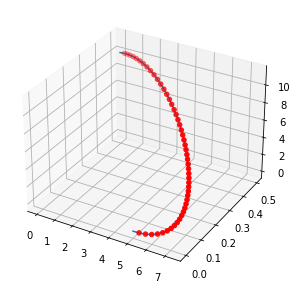

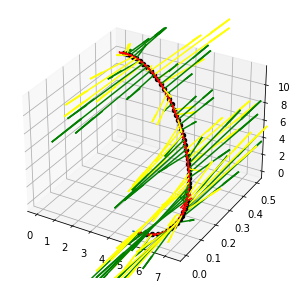

In [260]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev, splint, spalde

def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

def get_curve_coordinates(nodes,n,d):
    
    # here we make the spline, with tck the vector of knots, the B-spline coefficients, and the degree of the spline, and u values of the parameter
    tck, u = splprep(nodes.T,s=0)

    # to create an more accurate spline we have to define the number of t values on which the spline is evaluated
    t = 1/n
    v = np.arange(0,1+t,t)

    # evalute spline to get the curve
    curve = np.array(splev(v,tck)).T
    der = np.array(splev(v,tck,der=1)).T
                   
    # instead we are going to do an arc length parameterization, by doing a numerical approximation to get a look up table for equally spaced distances
    # calculate distances between each t value in the curve
    inter_distances = np.sqrt(np.sum(np.diff(curve,axis=0)**2,axis=1))

    # summing interdistances results in total arc length
    arc_length = np.sum(inter_distances)

    # cumulative sum of interdistances results in input for lookup table
    cum_length = np.cumsum(inter_distances)
    
    # here d is the stepsize in terms of distance along that curve that is used to choose points that are equally spaced along the curve
    indices = [find_nearest(cum_length,d) for d in np.arange(d,arc_length,d)]
    points = curve[indices]
    
    # might need to adjust the point locator, because now the points are equidistant along the curve but not with respect of eachother
    # to make the points equidistant with respect of each other, compute pairwise distances and find distance that matches interval the best
    # although be careful that if a parallel path of the curve is closer than the next point along the curve
    
    tangents = (der.T/np.linalg.norm(der,axis=1)).T[indices]
    normals = np.rot90(tangents).T
    binormals = np.cross(tangents,normals,axis=1)
    vector_path = np.concatenate((points,normals,binormals,tangents),axis=1).reshape(len(points),4,3)

    return  points, vector_path, curve, arc_length

def norm(p):
    """Norm of points.
    
    Args:
        p (array of float): list of 3D points.
        
    Returns:
        array of float.
    
    """
    
    if len(p.shape)==2: # list of points
        return np.sqrt(np.sum(p**2,axis=1))
    elif len(p.shape)==1: # only one point
        return np.sqrt(np.sum(p**2))
    else:
        raise ValueError('Accept only vector or array of vectors.')
        
def get_curve_coordinates(nodes,n,d,curve_tangent=True):
    
    # here we make the spline, with tck the vector of knots, the B-spline coefficients, and the degree of the spline, and u values of the parameter
    tck, u = splprep(nodes.T,s=0)

    # to create an more accurate spline we have to define the number of t values on which the spline is evaluated
    t = 1/n
    v = np.arange(0,1+t,t)

    # evalute spline to get the curve
    curve = np.array(splev(v,tck)).T
    der1 = np.array(splev(v,tck,der=1)).T
    der2 = np.array(splev(v,tck,der=2)).T
                   
    # instead we are going to do an arc length parameterization, by doing a numerical approximation to get a look up table for equally spaced distances
    # calculate distances between each t value in the curve
    inter_distances = np.sqrt(np.sum(np.diff(curve,axis=0)**2,axis=1))

    # summing interdistances results in total arc length
    arc_length = np.sum(inter_distances)

    # cumulative sum of interdistances results in input for lookup table
    cum_length = np.cumsum(inter_distances)
    
    # here d is the stepsize in terms of distance along that curve that is used to choose points that are equally spaced along the curve
    indices = [find_nearest(cum_length,d) for d in np.arange(d,arc_length,d)]
    points = curve[indices]
    
        
    # might need to adjust the point locator, because now the points are equidistant along the curve but not with respect of eachother
    # to make the points equidistant with respect of each other, compute pairwise distances and find distance that matches interval the best
    # although be careful that if a parallel path of the curve is closer than the next point along the curve
    
    # compute curvature (det of der1,der2 / abs(der1)^3)
    # det(P',P'') / |P'|^3
    der1norm = norm(der1)
    cp = np.cross(der1,der2)
    cpnorm = norm(cp)

    res = np.zeros(len(cpnorm))
    idx = np.argwhere(der1norm!=0).flatten()
    if len(idx)!=0:
        res[idx]  = cpnorm[idx]/(der1norm[idx]**3)
    
    curvature = res

    tangents = (der1.T/np.linalg.norm(der1,axis=1)).T[indices]
    normals = np.rot90(tangents).T
    binormals = np.cross(tangents,normals,axis=1)
    vector_path = np.concatenate((points,normals,binormals,tangents),axis=1).reshape(len(points),4,3)
    
    
    if curve_tangent:
        # this gives curve tangents 
        tangents = (der1.T/np.linalg.norm(der1,axis=1)).T[indices]
        normals = np.rot90(tangents).T
        binormals = np.cross(tangents,normals,axis=1)
        vector_path = np.concatenate((points,normals,binormals,tangents),axis=1).reshape(len(points),4,3)
#     normals = np.rot90(tangents).T
#     binormals = np.cross(tangents,normals,axis=1)
#     vector_path = np.concatenate((points,normals,binormals,tangents),axis=1).reshape(len(points),4,3)
    
#     new_inter_distances = np.sqrt(np.sum(np.diff(points,axis=0)**2,axis=1))
    else:
        # this gives point to point vector
        diffs = np.diff(points,axis=0)
        tangents = (diffs.T/np.linalg.norm(diffs,axis=1)).T
        normals = np.rot90(tangents).T
        binormals = np.cross(tangents,normals,axis=1)
        points = points[:-1]
        vector_path = np.concatenate((points,normals,binormals,tangents),axis=1).reshape(len(points),4,3)
#     new_inter_distances = np.sqrt(np.sum(np.diff(points,axis=0)**2,axis=1))
    
#     diffs = np.diff(points,axis=0)
#     normals = (diffs.T/np.linalg.norm(diffs,axis=1)).T
#     orthos = np.rot90(normals.T)
#     binormals = np.cross(normals,orthos)
    
#     vector_path = np.concatenate((points[:-1],binormals,orthos,normals),axis=1).reshape(len(points)-1,4,3)
    
    
    
    return  points, vector_path, curve, arc_length,curvature


def rotve(v,erot,angle):
    rotmeasure=np.linalg.norm(erot)
    erot=erot/rotmeasure;
    norme=np.dot(v,erot)
    vplane=v-norme*erot
    plnorm=np.linalg.norm(vplane)
    ep=vplane/plnorm
    eo=np.cross(erot,ep)
    vrot=(np.cos(angle)*ep+np.sin(angle)*eo)*plnorm+norme*erot
    return(vrot)

def twist_vector_path(vector_path,twist):
    
    for idx in range(len(vector_path)):
        # rotate along tangent
        R = vector_path[idx]
        R[1] = rotve(R[1],R[3],twist*idx)
        R[2] = rotve(R[2],R[3],twist*idx)
        B = R[1:]
        B_ = B/np.linalg.norm(B)
        R = np.vstack((R[0],B_))
        vector_path[idx] = R
        
    return vector_path


def plot_B(ax,B,alpha=1,ls='-'):
    a = B[0][:3] 
    ax.scatter(a[0],a[1],a[2],c='k')
    ax.quiver(a[0],a[1],a[2],B[1][0],B[1][1],B[1][2],color='yellow',alpha=alpha,ls=ls) # normal
    ax.quiver(a[0],a[1],a[2],B[2][0],B[2][1],B[2][2],color='green',alpha=alpha,ls=ls) #binormal
    ax.quiver(a[0],a[1],a[2],B[3][0],B[3][1],B[3][2],color='red',alpha=alpha,ls=ls) #tangent
    
def plot_vector_path(V):
    fig = plt.figure(figsize=[5,5])
    ax = fig.add_subplot(projection='3d')
    for i in range(len(V)):
        plot_B(ax,V[i])
    return ax 
    
def generate_curve(nodes,d,n = 1000,twist=True,plot_curve=False,plot_path=True,verbose=False,curve_tangent=True):
    
    
    points, vector_path, curve, arc_length,curvature = get_curve_coordinates(nodes,n,d,curve_tangent=curve_tangent)
    
    print(f'Generated a curve based on {len(nodes)} nodes and arclength {np.round(arc_length,2)} with {len(points)} equidistant points.')
    if twist:
        twist  = np.deg2rad(360/10.5)
        vector_path_twisted = twist_vector_path(vector_path,twist)
        V = vector_path_twisted
    else:
        V =  vector_path
        
    if plot_curve:
        fig = plt.figure(figsize=[5,5])
        ax = fig.add_subplot(projection='3d')
        ax.plot(curve[:, 0], curve[:, 1], curve[:, 2])
        ax.scatter(points[:, 0],points[:, 1],points[:, 2],c='red')
        
    if plot_path:
        ax = plot_vector_path(V)
        ax.plot(curve[:, 0], curve[:, 1], curve[:, 2])
        
    return V
    
d = 0.34 # interspaced distantance
nodes =  np.array([[1, 0, 0],[1.01, 0, 0],[1.01, 0.05, 2],[0, 0.1, 2]])*5

V = generate_curve(nodes,d,twist=True,plot_path=True,plot_curve=True,verbose=True,curve_tangent=False)

In [242]:
A = md.load('./atomic/BDNA_A.pdb')
T = md.load('./atomic/BDNA_T.pdb')
G = md.load('./atomic/BDNA_G.pdb')
C = md.load('./atomic/BDNA_C.pdb')
DNA = md.load('./dry_0.pdb')
base = DNA.atom_slice(DNA.top.select('not protein and resid 1 22'))

In [243]:
A = md.load('./atomic/BDNA_A.pdb')
T = md.load('./atomic/BDNA_T.pdb')
G = md.load('./atomic/BDNA_G.pdb')
C = md.load('./atomic/BDNA_C.pdb')
DNA = md.load('./dry_0.pdb')
base = DNA.atom_slice(DNA.top.select('not protein and resid 1 22'))
A.xyz = -A.xyz+1
T.xyz = T.xyz+1
AT = T.stack(A)

baseref_A = collect_base_reference_frames(A,reference_bases['DA'])[0]
baseref_T = collect_base_reference_frames(T,reference_bases['DT'])[0]
midframe = base_refs_to_midframe(baseref_A,baseref_T)
# midframe
B1 = np.round(baseref_T,1)
B1

array([[ 1.,  1.,  1.],
       [ 1., -0.,  0.],
       [ 0.,  1., -0.],
       [-0.,  0.,  1.]])

In [15]:
view = nv.show_mdtraj(base)
view

NGLWidget()

Generated a curve based on 4 nodes and arclength 8.31 with 24 equidistant points.
<mdtraj.Topology with 48 chains, 48 residues, 984 atoms, 552 bonds>


NGLWidget()

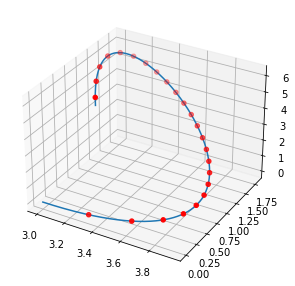

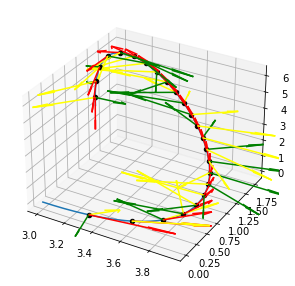

In [267]:
from copy import *
def transform_base(base,u,v):
    traj = deepcopy(base)
    

    xyz = traj.xyz[0]
    M = np.linalg.solve(u[1:],v[1:])
    o  = u[0] @ M
    trans = v[0] - o
    new_xyz = (xyz @ M) + trans
    # fig = plt.figure(figsize=[5,5])
    # ax = fig.add_subplot(projection='3d')
    # plot_B(ax,u)
    # plot_B(ax,v,ls='--')
    # ax.scatter(xyz.T[0],xyz.T[1],xyz.T[2],c='purple')
    # ax.scatter(new_xyz.T[0],new_xyz.T[1],new_xyz.T[2],c='red')
    traj.xyz = new_xyz
    
    return traj

def norm_vector(vector):
    return vector/np.linalg.norm(vector)

def transform_base(base,u,v):
    traj = deepcopy(base)
    

    xyz = traj.xyz[0]
    
    M = np.linalg.solve(norm_vector(u[1:]),norm_vector(v[1:]))
    #M = np.array([[0.5, -0.5, 0], [0.5, 0.5, 0], [0,0,1]])
    # M = np.array([[1,1,0],[1,1,0],[0,0,1]])
    #o  = u[0] @ M
    o = np.dot(u[0],M)
    o = u[0]
    trans = v[0] - o
    
    # rotate subject on target
    #new_xyz =np.array([np.dot(i.T,M).T for i in xyz])
   
    new_xyz = np.dot(xyz, M) + trans
    #print(np.mean(xyz,axis=0),trans,np.mean(new_xyz,axis=0))
    #new_xyz = xyz + trans
    # fig = plt.figure(figsize=[5,5])
    # ax = fig.add_subplot(projection='3d')
    # plot_B(ax,u)
    # plot_B(ax,v,ls='--')
    # ax.scatter(xyz.T[0],xyz.T[1],xyz.T[2],c='purple')
    # ax.scatter(new_xyz.T[0],new_xyz.T[1],new_xyz.T[2],c='red')
    traj.xyz = new_xyz
    
    return deepcopy(traj)

def add_base(traj,base):
    return deepcopy(traj.stack(base))

def join_bases(bases):
    traj = deepcopy(bases[0])
    for base in bases[1:]:
        traj = deepcopy(add_base(traj,base))
    return traj

d = 0.34 # interspaced distantance
nodes =  np.array([[1, 0, 0],[1.01, 0, 0],[1.01, 0.5, 2],[1.1, 0.1, 2]])*3
#nodes =  np.array([[1, 0, 0],[1.01, 0, 0],[1.01, 2.05, 2],[1.1, 2.1, 2]])*10
V = generate_curve(nodes,d,twist=True,plot_path=True,plot_curve=True,verbose=True,curve_tangent=True)

A = md.load('./atomic/BDNA_A.pdb')
T = md.load('./atomic/BDNA_T.pdb')
A.xyz = -A.xyz+0.0001
T.xyz = T.xyz+0.0001
AT = T.stack(A)

baseref_A = collect_base_reference_frames(A,reference_bases['DA'])[0]
baseref_T = collect_base_reference_frames(T,reference_bases['DT'])[0]
midframe = base_refs_to_midframe(baseref_A,baseref_T)
# midframe
B1 = np.round(baseref_T,1)


ATs = [transform_base(AT,B1,v) for v in V]
DNA = join_bases(ATs)
print(DNA.top)

view = nv.show_mdtraj(DNA)
view.clear()
view.add_representation('ball+stick')
view

In [163]:
B1 = baseref_T
AT = T

In [152]:
def _compute_distance(xyz, pairs):
    "Distance between pairs of points in each frame"
    delta = np.diff(xyz[:, pairs], axis=2)[:, :, 0]
    return (delta ** 2.).sum(-1) ** 0.5

def get_sum_dist(traj):    
    n = traj.xyz[0].shape[0]
    pairs = np.array([[i,j]for i in range(n) for j in range(n)])
    new_dist = _compute_distance(traj.xyz,pairs)
    print(np.sum(new_dist))

In [193]:
# A = md.load('./atomic/BDNA_A.pdb')
# T = md.load('./atomic/BDNA_T.pdb')
# A.xyz = -A.xyz+0.0001
# T.xyz = T.xyz+0.0001
# AT = T.stack(A)

xyz = deepcopy(AT.xyz[0])

u = B1[1:]
norm = np.linalg.norm(u)
u = u/norm
u_o = B1[0]
v = V[1][1:]
v_o = V[1][0]
print(u)

M = np.linalg.solve(u,v)
print(M)
o  = u_o @ M
trans = v_o - o
new_xyz = (xyz @ M) + trans
    
new_xyz = np.dot(xyz, M.T) 
new_xyz = xyz + trans
new_AT = deepcopy(AT)
new_AT.xyz = new_xyz


view = nv.show_mdtraj(new_AT)
view.clear()
view.add_representation('ball+stick')


    
get_sum_dist(AT)
get_sum_dist(new_AT)

# n = new_xyz.shape[0]
# pairs = np.array([[i,j]for i in range(n) for j in range(n)])
# new_dist = _compute_distance(np.array([new_xyz]),pairs)
# print(np.sum(new_dist))
# new_dist = _compute_distance(np.array([xyz]),pairs)
# print(np.sum(new_dist))

view

[[ 0.57735027 -0.         -0.        ]
 [ 0.          0.57735027  0.        ]
 [ 0.         -0.          0.57735027]]
[[-3.94995770e-01  9.00546335e-01  1.78859430e-01]
 [ 9.18154530e-01  3.79976070e-01  1.14509467e-01]
 [ 4.71139590e-04 -1.94657096e-01  9.81127089e-01]]
1348.3872
1348.3872


NGLWidget()

In [170]:
xyz.shape

(20, 3)

In [168]:
new_xyz.shape

(20, 3)

(-2.0, 2.0)

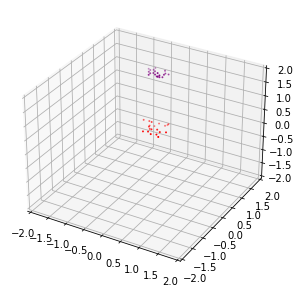

In [179]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(projection='3d')
# plot_B(ax,u)
# plot_B(ax,v,ls='--')
ax.scatter(xyz.T[0],xyz.T[1],xyz.T[2],c='red',s=1)
ax.scatter(new_xyz.T[0],new_xyz.T[1],new_xyz.T[2],c='purple',s=1)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)

In [127]:

#AT_.xyz[0] = AT_.xyz[0] @ np.array([[0.5, -0.5, 0], [0.5, 0.5, 0], [0,0,1]])
rot = np.array([[0.5, -0.5, 0], [0.5, 0.5, 0], [0,0,1]])
# rot = M
traj = deepcopy(AT)
old_traj = deepcopy(AT)

# get xyz coordinates
xyz = old_traj.xyz[0]

com =  np.mean(xyz,axis=0)
o  = com @ rot
trans = (com - o) 

# print(com,o,trans)

# rotate subject on target
#new_xyz = np.array([np.dot(i, rot) for i in xyz]) + trans
new_xyz = deepcopy(xyz @ rot)
# replace coordinates of traj
traj.xyz = new_xyz
print(traj)    

T = old_traj.stack(traj,keep_resSeq=True)
view = nv.show_mdtraj(T)
#view = nv.show_mdtraj(traj)
view.clear()
view.add_representation('ball+stick')
view

<mdtraj.Trajectory with 1 frames, 41 atoms, 2 residues, without unitcells>


NGLWidget()

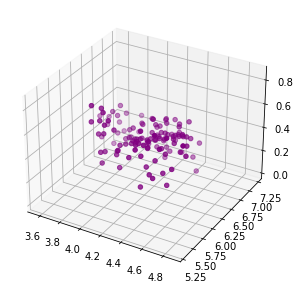

In [22]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(projection='3d')
# plot_B(ax,u)
# plot_B(ax,v,ls='--')
ax.scatter(T.xyz.T[0],T.xyz.T[1],T.xyz.T[2],c='purple')

In [15]:
from copy import *
def transform_base(base,u,v):
    traj = deepcopy(base)


    xyz = traj.xyz[0]
    M = np.linalg.solve(u[1:],v[1:])
    o  = u[0] @ M
    trans = v[0] - o
    new_xyz = (xyz @ M) + trans
    # fig = plt.figure(figsize=[5,5])
    # ax = fig.add_subplot(projection='3d')
    # plot_B(ax,u)
    # plot_B(ax,v,ls='--')
    # ax.scatter(xyz.T[0],xyz.T[1],xyz.T[2],c='purple')
    # ax.scatter(new_xyz.T[0],new_xyz.T[1],new_xyz.T[2],c='red')
    traj.xyz = new_xyz
    
    return traj


# def transform_base(base,u,v):
    
#     # get xyz coordinates
#     xyz = base.xyz[0]
    
#     M = np.linalg.solve(u[1:],v[1:])
#     M = np.array([[0.5, -0.5, 0], [0.5, 0.5, 0], [0,0,1]])
#     o  = np.dot(u[0], M)
#     trans = v[0] - o
    
#     # rotate subject on target
#     new_xyz = np.dot(xyz, M)

#     # replace coordinates of traj
#     base.xyz = new_xyz
#     return base

def add_base(traj,base):
    return deepcopy(traj.stack(base))

def join_bases(bases):
    traj = deepcopy(bases[0])
    for base in bases[1:]:
        traj = add_base(traj,base)
    return traj

ATs = [transform_base(AT,B1,v) for v in V]

DNA = join_bases(ATs[:1])
# ATs = [change_xyz_base(AT,B,v) for v in V]
# traj = None
# traj = ATs[0]
# for v,t in zip(V,ATs[1:]):
#     # print(v[0])
#     # print(np.mean(t.xyz.T[0]),np.mean(t.xyz.T[1]),np.mean(t.xyz.T[2]))
#     traj = traj.stack(t)

view = nv.show_mdtraj(DNA)
view.clear()
view.add_representation('ball+stick')
view

NGLWidget()

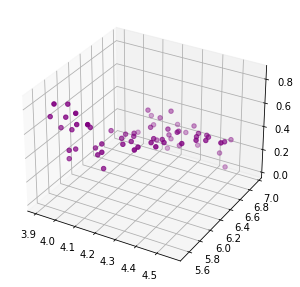

In [2316]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(projection='3d')
# plot_B(ax,u)
# plot_B(ax,v,ls='--')
ax.scatter(traj.xyz.T[0],traj.xyz.T[1],traj.xyz.T[2],c='purple')
# ax.scatter(new_xyz.T[0],new_xyz.T[1],new_xyz.T[2],c='red')

In [2321]:
view = nv.show_mdtraj(DNA)
view.clear()
view.add_representation('ball+stick')
view

NGLWidget()

In [44]:
base = AT
xyz = AT.xyz[0]
print(xyz.shape,np.mean(xyz))
u = B1
v = V[0]

print(v[0],u[0])
print(trans)
M = np.linalg.solve(u[1:],v[1:])
o  = u[0] @ M
trans = v[0] - o
new_xyz =  xyz @ M  + trans

(41, 3) 0.009977239
[ 3.21213469 -0.15185618  0.56742021] [0. 0. 0.]
[-0.00170728  0.01489508  0.        ]


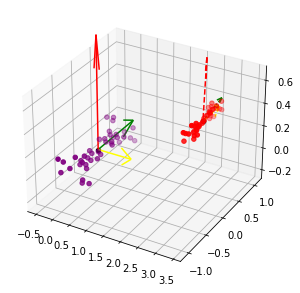

In [45]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(projection='3d')
plot_B(ax,u)
plot_B(ax,v,ls='--')
ax.scatter(xyz.T[0],xyz.T[1],xyz.T[2],c='purple')
ax.scatter(new_xyz.T[0],new_xyz.T[1],new_xyz.T[2],c='red')

In [286]:
T1 = B1[1:]
T2 = B2[1:]
extract_Omegas(np.matmul(T2.T,T1))

/var/folders/n2/v5z2p1nn4f3bx7dhf2zlzdjw0000gn/T/ipykernel_79625/2867838317.py:184: RuntimeWarning: invalid value encountered in double_scalars
  Omegavec    = Omega*1./(2*np.sin(Omega))*np.array([R[2,1]-R[1,2],R[0,2]-R[2,0],R[1,0]-R[0,1]])


array([nan, nan, nan])

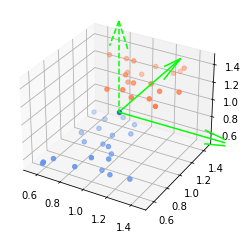

In [1983]:
def plot_B(ax,B,c='cornflowerblue'):
    a = B[0][:3]
    ax.scatter(a[0],a[1],a[2])
    x = ax.quiver(a[0],a[1],a[2],B[1][0],B[1][1],B[1][2],color=c) #x-axis
    y = ax.quiver(a[0],a[1],a[2],B[2][0],B[2][1],B[2][2],color=c) #y-axis
    z = ax.quiver(a[0],a[1],a[2],B[3][0],B[3][1],B[3][2],color=c,ls='--') #z-axis
    return x,y,z
    
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# Q = plot_B(ax,baseref_T,c='coral')
Q = plot_B(ax,B1,c='lime')
# Q = plot_B(ax,baseref_A)
# plot_B(ax,B2)
X = np.dot(B1[0],B1[1])
ax.set_xlim(0.5,1.5)
ax.set_ylim(0.5,1.5)
ax.set_zlim(0.5,1.5)
ax.scatter(A.xyz.T[0],A.xyz.T[1],A.xyz.T[2],c='cornflowerblue')
ax.scatter(T.xyz.T[0],T.xyz.T[1],T.xyz.T[2],c='coral')



12 44.10317541342687


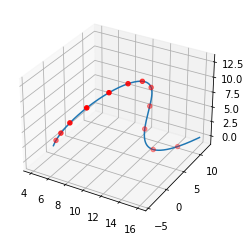

In [1874]:
# combine everything 
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev, splint, spalde

def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

def get_curve_coordinates(nodes,n,d):
    
    # here we make the spline, with tck the vector of knots, the B-spline coefficients, and the degree of the spline, and u values of the parameter
    tck, u = splprep(nodes.T,s=0)

    # to create an more accurate spline we have to define the number of t values on which the spline is evaluated
    t = 1/n
    v = np.arange(0,1+t,t)

    # evalute spline to get the curve
    curve = np.array(splev(v,tck)).T
    der = np.array(splev(v,tck,der=1)).T
                   
    # instead we are going to do an arc length parameterization, by doing a numerical approximation to get a look up table for equally spaced distances
    # calculate distances between each t value in the curve
    inter_distances = np.sqrt(np.sum(np.diff(curve,axis=0)**2,axis=1))

    # summing interdistances results in total arc length
    arc_length = np.sum(inter_distances)

    # cumulative sum of interdistances results in input for lookup table
    cum_length = np.cumsum(inter_distances)
    
    # here d is the stepsize in terms of distance along that curve that is used to choose points that are equally spaced along the curve
    indices = [find_nearest(cum_length,d) for d in np.arange(d,arc_length,d)]
    points = curve[indices]
    
    tangents = (der.T/np.linalg.norm(der,axis=1)).T[indices]
    normals = np.rot90(tangents).T
    binormals = np.cross(tangents,normals,axis=1)
    vector_path = np.concatenate((points,normals,tangents,binormals),axis=1).reshape(len(points),4,3)

    return  points, vector_path, curve, arc_length

d = 3.4 # interspaced distantance
n = 1000 # number of t values for fit
nodes =  np.array([[1, 0, 0], [3, 1, 3],[3, 2, 2],[3, 1.5, 0.5], [4, 3, 0]])*4
#nodes =  np.array([[1, 0, 0],[1, 0.1, 0],[1, 3.1, 1],[1.5, 3, 1]])*5
#nodes =  np.array([[1, 0, 0],[1.01, 0, 0],[1.01, 0.05, 3],[1, 0.1, 3]])*10


points, vector_path, curve, arc_length = get_curve_coordinates(nodes,n,d)
print(len(points),arc_length)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(curve[:, 0], curve[:, 1], curve[:, 2])
ax.scatter(points[:, 0],points[:, 1],points[:, 2],c='red')

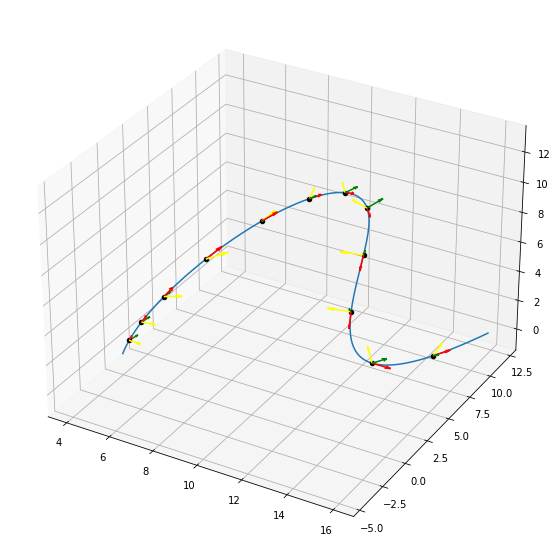

In [1875]:
def plot_B(ax,B):
    a = B[0][:3] 
    ax.scatter(a[0],a[1],a[2],c='k')
    ax.quiver(a[0],a[1],a[2],B[1][0],B[1][1],B[1][2],color='yellow') # normal
    ax.quiver(a[0],a[1],a[2],B[2][0],B[2][1],B[2][2],color='red') # tangent
    ax.quiver(a[0],a[1],a[2],B[3][0],B[3][1],B[3][2],color='green') # binormal
   
    
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(projection='3d')
for i in range(len(points)):
    plot_B(ax,vector_path[i])
ax.plot(curve[:, 0], curve[:, 1], curve[:, 2])

In [1876]:
def rotve(v,erot,angle):
    rotmeasure=np.linalg.norm(erot)
    erot=erot/rotmeasure;
    norme=np.dot(v,erot)
    vplane=v-norme*erot
    plnorm=np.linalg.norm(vplane)
    ep=vplane/plnorm
    eo=np.cross(erot,ep)
    vrot=(np.cos(angle)*ep+np.sin(angle)*eo)*plnorm+norme*erot
    return(vrot)

def twist_vector_path(vector_path,twist):
    
    for idx in range(len(vector_path)):
        # rotate along tangent
        R = vector_path[idx]
        R[1] = rotve(R[1],R[2],twist*idx)
        R[3] = rotve(R[3],R[2],twist*idx)
        B = R[1:]
        B_ = B/np.linalg.norm(B)
        R = np.vstack((R[0],B_))
        vector_path[idx] = R
        
    return vector_path

twist  = np.deg2rad(360/10.5)
vector_path_twisted = twist_vector_path(vector_path,twist)
V = vector_path_twisted

(12, 4, 3)

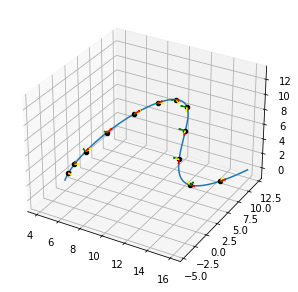

In [1877]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(projection='3d')
for i in range(len(points)):
    plot_B(ax,vector_path_twisted[i])
ax.plot(curve[:, 0], curve[:, 1], curve[:, 2])
vector_path_twisted.shape

In [1849]:
norm = np.linalg.norm(V[0][1:])
norm

1.5107016528495982

Text(0.5, 0, 'Z (Mpc)')

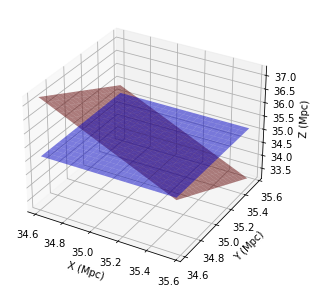

In [2002]:
import matplotlib.pyplot as plt
import numpy as np
import math

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

cen_x, cen_y, cen_z = 35.112, 35.112, 35.112
origin = np.array([[cen_x,cen_y,cen_z]])

z_plane_norm = np.array([1,1,0])
z_plane_norm = unit_vector(z_plane_norm)

normal = np.array([np.random.uniform(-1,1),np.random.uniform(-1,1),np.random.uniform(0,1)])
normal = unit_vector(normal)

a1 = normal[0]
b1 = normal[1]
c1 = normal[2]

rot = np.matrix([[b1/math.sqrt(a1**2+b1**2),-1*a1/math.sqrt(a1**2+b1**2), 0], 
                 [a1*c1/math.sqrt(a1**2+b1**2), b1*c1/math.sqrt(a1**2+b1**2), -1*math.sqrt(a1**2+b1**2)], 
                 [a1, b1, c1]])

init = np.matrix(normal)

fin = rot*init.T
fin = np.array(fin)

# equation for a plane is a*x+b*y+c*z+d=0 where [a,b,c] is the normal
# so calculate d from the normal
d1 = -origin.dot(normal)

# create x,y
xx, yy = np.meshgrid(np.arange(cen_x-0.5,cen_x+0.5,0.05),np.arange(cen_y-0.5,cen_y+0.5,0.05))

# calculate corresponding z
z1 = (-a1 * xx - b1 * yy - d1) * 1./c1

#-------------

a2 = fin[0][0]
b2 = fin[1][0]
c2 = fin[2][0]

d2 = -origin.dot(fin)
d2 = np.array(d2)
d2 = d2[0][0]

z2 = (-a2 * xx - b2 * yy - d2) * 1./c2

#-------------

# plot the surface
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(projection='3d')

ax.plot_surface(xx, yy, z1, color='r', alpha=0.5, label = "original")   
ax.plot_surface(xx, yy, z2, color='b', alpha=0.5, label = "rotated")  


ax.set_xlabel('X (Mpc)')
ax.set_ylabel('Y (Mpc)')
ax.set_zlabel('Z (Mpc)')

In [1821]:

def get_rot_and_trans(x,y):
    
    """ fit only works now on a single frame (mdtraj returns xyz with shape (n_frames, atoms, xyz) 
         even for single frame trajs so hence the xyz[0]"""
    
    # load super imposer
    sup = SVDSuperimposer()

    # # Set the coords, y will be rotated and translated on x
    sup.set(x, y)

    # Do the leastsquared fit
    sup.run()

    # Get the rms
    rms = sup.get_rms()

    # Get rotation (right multiplying!) and the translation
    rot, tran = sup.get_rotran()
    
    # now we have the instructions to rotate B on A
    return rot,tran,rms

def apply_superimposition(traj, rot, tran):
    
    # get xyz coordinates
    xyz = traj.xyz[0]
    
    # rotate subject on target
    new_xyz = dot(xyz, rot) + tran

    # replace coordinates of traj
    traj.xyz = new_xyz
    return traj

def get_rigid_cooridnate(B):
    return np.vstack((B[0],B[0] + 1 * B[1:]))


In [1923]:
A = md.load('./atomic/BDNA_A.pdb')
T = md.load('./atomic/BDNA_T.pdb')
G = md.load('./atomic/BDNA_G.pdb')
C = md.load('./atomic/BDNA_C.pdb')

A.xyz = -A.xyz+1
T.xyz = T.xyz+1
AT = T.stack(A)

view = nv.show_mdtraj(AT)
view

NGLWidget()

In [1927]:
AT.top

<mdtraj.Topology with 2 chains, 2 residues, 41 atoms, 23 bonds at 0x19b4bf520>

In [1926]:
base_names = 'name N1 N7 C8 N9 C4 C5 C6 C2 N3 N6 O2 O4 H2 H62 H61 H3 C7'

basepair = AT
basis = basepair.atom_slice(basepair.top.select(f'{base_names}'))
origin = np.mean(basis.xyz,axis=1) # COM of nucleobases
origin

array([[1.0162222, 1.0095389, 1.       ]], dtype=float32)

In [1917]:
def change_xyz_base(base,A,B):

    xyz_A = get_rigid_cooridnate(A)
    xyz_B = get_rigid_cooridnate(B)

    rot,tran,rms = get_rot_and_trans(xyz_A,xyz_B)
    new_base = apply_superimposition(base,rot,tran)
    print(np.mean(new_base.xyz,axis=1))
    
    return copy(new_base)

baseref_A = collect_base_reference_frames(A,reference_bases['DA'])[0]
baseref_T = collect_base_reference_frames(T,reference_bases['DT'])[0]
midframe = base_refs_to_midframe(baseref_A,baseref_T)
# midframe
B = np.round(baseref_T,1)
B

array([[ 1.,  1.,  1.],
       [ 1., -0.,  0.],
       [ 0.,  1., -0.],
       [-0.,  0.,  1.]])

In [1903]:
W

array([[ 0.50966051, -0.3397832 ,  0.25092528],
       [ 0.25092528, -0.3397832 ,  0.50966051],
       [ 0.13281165,  0.29729149,  0.13281165]])

In [1918]:
trans = V[0][0]-B[0]
trans

array([ 4.22034296, -2.83797862,  1.50739121])

In [1905]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

# rotation_matrix_from_vectors(v[0],W[0])


In [1906]:
v = B[1:]
W = V[0][1:]
norm = np.linalg.norm(W)
W = W/norm
print(norm)
M = np.linalg.solve(v,W)
M

1.0


array([[ 0.50966051, -0.3397832 ,  0.25092528],
       [ 0.25092528, -0.3397832 ,  0.50966051],
       [ 0.13281165,  0.29729149,  0.13281165]])

In [1913]:
# xyz_norm = np.linalg.norm(AT.xyz,axis=1)
v_new = np.dot(AT.xyz/xyz_norm,M)
# AT.xyz = v_new * xyz_norm + trans
AT.xyz = AT.xyz + trans

In [1915]:
AT.xyz

array([[[ 5.190343  , -0.89727855,  2.3547912 ],
        [ 5.182443  , -0.76367855,  2.2914913 ],
        [ 5.291543  , -0.9126786 ,  2.4615912 ],
        [ 5.046343  , -0.9386786 ,  2.4107912 ],
        [ 4.952743  , -1.0028787 ,  2.322091  ],
        [ 4.885543  , -1.1189786 ,  2.3926911 ],
        [ 4.960643  , -1.2430786 ,  2.3790913 ],
        [ 4.867143  , -1.1033785 ,  2.5435913 ],
        [ 4.743043  , -1.1619786 ,  2.5810912 ],
        [ 4.980343  , -1.1858785 ,  2.605091  ],
        [ 4.972243  , -1.3025787 ,  2.5073912 ],
        [ 5.091943  , -1.3879786 ,  2.5073912 ],
        [ 5.074143  , -1.5244787 ,  2.5073912 ],
        [ 4.964143  , -1.5771786 ,  2.5073912 ],
        [ 5.190543  , -1.5972786 ,  2.5073912 ],
        [ 5.319743  , -1.5482786 ,  2.5073912 ],
        [ 5.414743  , -1.6260786 ,  2.5073912 ],
        [ 5.330943  , -1.4041786 ,  2.5073912 ],
        [ 5.466943  , -1.3418787 ,  2.507491  ],
        [ 5.217943  , -1.3322786 ,  2.5073912 ],
        [ 5.2502427 

In [1914]:
view = nv.show_mdtraj(AT)
view

NGLWidget()

In [1880]:
ATs = [change_xyz_base(AT,B,v) for v in V]

[[-1.6506188  1.0492865  6.0327287]]
[[-7.174335  -1.4759943  4.77438  ]]
[[-9.467599 -8.941217  7.446171]]
[[ -5.426545  -17.671564    4.8296895]]
[[-19.494812   -5.9522185  12.745967 ]]
[[-30.576426   -2.089546    6.2551174]]
[[-33.597366  -24.801714    1.0463686]]
[[-14.65823    -52.84859     -0.22968483]]
[[-17.78245  -48.025436 -38.61614 ]]
[[-40.094193 -22.783892 -55.600597]]
[[ 67.48783   48.632336 -10.121047]]
[[-25.04574  30.11281 -52.5881 ]]


In [1826]:
# for t in ATs:
#     print(np.mean(t.xyz,axis=1))

In [1881]:
ATs = [change_xyz_base(AT,B,v) for v in V]

# ATs = [change_xyz_base(AT,B,v) for v in V]
traj = None
traj = ATs[0]
for t in ATs[1:]:
    print(np.mean(t.xyz))
    traj = traj.stack(t)
traj.xyz

-1.291983
-3.6542146
-6.089474
-4.233688
-8.803618
-19.11757
-22.578835
-34.808002
-39.492893
35.333042
-15.8403425


array([[[ -2.2243383 ,   0.36601356,   6.3213143 ],
        [ -2.2839622 ,   0.25098947,   6.392957  ],
        [ -2.2335098 ,   0.3624421 ,   6.173707  ],
        ...,
        [-25.093153  ,  30.032267  , -52.395496  ],
        [-25.085432  ,  30.060923  , -52.26573   ],
        [-25.028755  ,  30.18131   , -52.247368  ]]], dtype=float32)

In [1814]:
traj.xyz = traj.xyz/5

In [1882]:
view = nv.show_mdtraj(traj.center_coordinates())
view.clear()
view.add_representation('ball+stick')
view

NGLWidget()

In [1683]:
view = nv.show_mdtraj(new_AT.stack(AT))
view.clear()
view.add_representation('ball+stick')
view

NGLWidget()

In [1684]:
AT.xyz

array([[[ 7.341733 , -3.4337747,  4.0906405],
        [ 7.333094 , -3.5730207,  4.1401815],
        [ 7.379106 , -3.4176254,  3.948418 ],
        [ 7.2036343, -3.3581562,  4.1188664],
        [ 7.1833053, -3.2953756,  4.246912 ],
        [ 7.120972 , -3.1584525,  4.228309 ],
        [ 7.2209396, -3.0541055,  4.2097635],
        [ 7.0288897, -3.1432028,  4.1073093],
        [ 6.920649 , -3.057785 ,  4.1423635],
        [ 7.114553 , -3.0723782,  4.0021973],
        [ 7.1832886, -2.975553 ,  4.0977483],
        [ 7.3047986, -2.914113 ,  4.042234 ],
        [ 7.323058 , -2.7788723,  4.060274 ],
        [ 7.2433367, -2.7083929,  4.119893 ],
        [ 7.438723 , -2.7290401,  4.0056186],
        [ 7.5355005, -2.7993393,  3.9364395],
        [ 7.6343775, -2.7408798,  3.8930378],
        [ 7.5098376, -2.9407666,  3.9212701],
        [ 7.6090493, -3.0251231,  3.847661 ],
        [ 7.3972516, -2.9903293,  3.9742494],
        [ 7.7026553, -1.5697215,  3.9214804],
        [ 7.7111855, -1.4305547,  

In [1678]:
a = new_AT.stack(AT)
a.xyz

array([[[13.918654 , 13.075583 ,  8.429121 ],
        [13.9960375, 13.1869135,  8.3696575],
        [13.991067 , 12.990788 ,  8.526337 ],
        [13.785411 , 13.132908 ,  8.496547 ],
        [13.668063 , 13.150938 ,  8.414971 ],
        [13.545409 , 13.100834 ,  8.488628 ],
        [13.521179 , 12.95899  ,  8.465852 ],
        [13.5494585, 13.113557 ,  8.64086  ],
        [13.419192 , 13.146311 ,  8.687754 ],
        [13.585071 , 12.973292 ,  8.690461 ],
        [13.498086 , 12.896889 ,  8.591334 ],
        [13.533534 , 12.754713 ,  8.579053 ],
        [13.431449 , 12.662378 ,  8.577649 ],
        [13.313754 , 12.69326  ,  8.586094 ],
        [13.472567 , 12.531914 ,  8.565929 ],
        [13.602436 , 12.485831 ,  8.555732 ],
        [13.624065 , 12.365371 ,  8.545768 ],
        [13.704443 , 12.588204 ,  8.557876 ],
        [13.84811  , 12.547843 ,  8.547473 ],
        [13.665321 , 12.715791 ,  8.569281 ],
        [12.759806 , 11.584304 ,  8.687445 ],
        [12.682411 , 11.473116 ,  

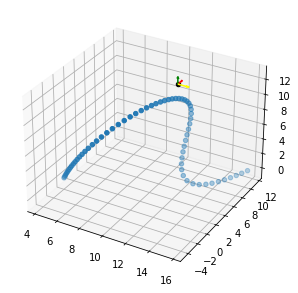

In [1601]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:, 0],points[:, 1],points[:, 2])
plot_B(ax,B1)

In [2013]:
v

array([[ 0.18945939,  0.50166211,  0.42777001],
       [ 0.33354567,  0.3181523 ,  0.50800917],
       [-0.17311827, -0.06769118,  0.15605812]])

In [2014]:
W

array([[ 0.30708867,  0.53851907, -0.27297252],
       [ 0.08773701,  0.66082347, -0.12014492],
       [-0.17078932, -0.0191114 , -0.2298375 ]])

In [2015]:
v = vector_path_twisted[3][1:]
# v = B1[1:]
W = vector_path_twisted[5][1:]

M = np.linalg.solve(v,W)
M

array([[ 0.09611946,  0.69005196,  0.92430892],
       [ 1.03522308,  0.19312237, -0.37354057],
       [-0.53873401,  0.72679259, -0.6094405 ]])

In [2016]:
v_new = np.dot(v,M)
v_new

array([[ 0.30708867,  0.53851907, -0.27297252],
       [ 0.08773701,  0.66082347, -0.12014492],
       [-0.17078932, -0.0191114 , -0.2298375 ]])

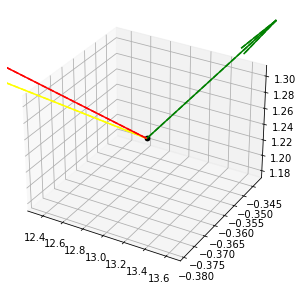

In [1573]:
def plot_B(ax,B,alpha=1,ls='-'):
    a = B[0][:3] 
    ax.scatter(a[0],a[1],a[2],c='k')
    ax.quiver(a[0],a[1],a[2],B[1][0],B[1][1],B[1][2],color='yellow',alpha=alpha,ls=ls)
    ax.quiver(a[0],a[1],a[2],B[2][0],B[2][1],B[2][2],color='red',alpha=alpha,ls=ls)
    ax.quiver(a[0],a[1],a[2],B[3][0],B[3][1],B[3][2],color='green',alpha=alpha,ls=ls)
    
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(projection='3d')

# plot_B(ax,np.vstack((np.array([0,0,0]),v)))
plot_B(ax,np.vstack((np.array(vector_path_twisted[0]),W)))
plot_B(ax,np.vstack((np.array(vector_path_twisted[0]),v_new)),ls='--')


In [1574]:
W

array([[-0.02608879,  0.99007263,  0.13811432],
       [-0.04430603, -0.189513  ,  0.98087807],
       [-0.99731499, -0.01947062, -0.04881035]])

In [1575]:
v_new

array([[-0.02608879,  0.99007263,  0.13811432],
       [-0.04430603, -0.189513  ,  0.98087807],
       [-0.99731499, -0.01947062, -0.04881035]])

In [1584]:
from copy import *
A = md.load('./atomic/BDNA_A.pdb')
T = md.load('./atomic/BDNA_T.pdb')
G = md.load('./atomic/BDNA_G.pdb')
C = md.load('./atomic/BDNA_C.pdb')

A.xyz = -A.xyz+10
T.xyz = T.xyz+10
AT = T.stack(A)
AT_new = copy(AT)
# AT_new.xyz[0] = np.dot(AT_new.xyz[0],M) 

#AT_new.xyz[0] = (M @ AT_new.xyz[0].T).T
AT_new = apply_superimposition(AT,M,[1,2,2])
# AT2 = md.join([AT,AT_new])
view = nv.show_mdtraj(AT_new.stack(AT))
view.clear()
view.add_representation('ball+stick')
view

NGLWidget()

In [1581]:
def get_rot_and_trans(subtraj_A,subtraj_B):
    
    """ fit only works now on a single frame (mdtraj returns xyz with shape (n_frames, atoms, xyz) 
         even for single frame trajs so hence the xyz[0]"""
    
    # load super imposer
    sup = SVDSuperimposer()

    # # Set the coords, y will be rotated and translated on x
    # x = subtraj_A.xyz[0]
    # y = subtraj_B.xyz[0]
    sup.set(subtraj_A, subtraj_B)

    # Do the leastsquared fit
    sup.run()

    # Get the rms
    rms = sup.get_rms()

    # Get rotation (right multiplying!) and the translation
    rot, tran = sup.get_rotran()
    
    # now we have the instructions to rotate B on A
    return rot,tran,rms

def apply_superimposition(traj, rot, tran):
    
    # get xyz coordinates
    xyz = traj.xyz[0]
    
    # rotate subject on target
    new_xyz = dot(xyz, rot) + tran

    # replace coordinates of traj
    traj.xyz = new_xyz
    return traj

In [1583]:
subtraj_A = A.atom_slice(A.top.select('name P'))
subtraj_B = T.atom_slice(T.top.select('name P'))
print(subtraj_A)

rot,trans,rms = get_rot_and_trans(B1[1:],W)

T_new = apply_superimposition(T,rot,0)

view = nv.show_mdtraj(A.stack(T_new))
view

<mdtraj.Trajectory with 1 frames, 1 atoms, 1 residues, without unitcells>


NGLWidget()

In [1386]:
import numpy as np
from scipy.spatial.transform import Rotation as R

In [1387]:
b1 = vector_path_twisted[1][1:]
b2 = vector_path_twisted[2][1:]

In [1391]:
r,rmsd = R.align_vectors(b2,b1)
b1_new = r.apply(b1,inverse=True)
#b1_new/np.linalg.norm(b1_new)
b1_new

array([[ 0.8736946 , -0.15535719,  0.46100096],
       [ 0.55845579, -0.14570385,  0.81663794],
       [ 0.05970096,  0.4560435 ,  0.04054054]])

In [1392]:
def plot_B(ax,B,alpha=1,ls='-'):
    a = B[0][:3] 
    ax.scatter(a[0],a[1],a[2],c='k')
    ax.quiver(a[0],a[1],a[2],B[1][0],B[1][1],B[1][2],color='yellow',alpha=alpha,ls=ls)
    ax.quiver(a[0],a[1],a[2],B[2][0],B[2][1],B[2][2],color='red',alpha=alpha,ls=ls)
    ax.quiver(a[0],a[1],a[2],B[3][0],B[3][1],B[3][2],color='green',alpha=alpha,ls=ls)

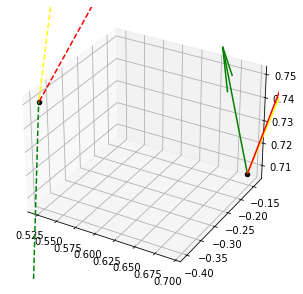

In [1395]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(projection='3d')

plot_B(ax,np.vstack((np.array(b2[0]),b2)))
plot_B(ax,np.vstack((np.array(b1[0]),b1)),ls='--')
# plot_B(ax,np.vstack((np.array(b1[0]),b1_new)),alpha=0.5)


In [1319]:
r,rmsd = R.align_vectors(B1[1:],b1)
b1_new = r.apply(B1,inverse=False)
#b1_new/np.linalg.norm(b1_new)
b1_new

array([[ 5.85128779e+00,  1.41086563e+01,  8.16751169e+00],
       [-3.62975047e-03,  9.27165804e-01, -3.74633683e-01],
       [-3.48531507e-01,  3.49972089e-01,  8.69508669e-01],
       [ 9.37290037e-01,  1.33727742e-01,  3.21876184e-01]])

In [1368]:
B1

array([[10., 10., 10.],
       [ 1., -0.,  0.],
       [ 0.,  1., -0.],
       [-0.,  0.,  1.]])

In [1370]:
B2 = vector_path_twisted[0]
B2

array([[11.09091407, -0.0356085 ,  0.11824339],
       [ 0.23406702, -0.06998583,  0.96969821],
       [ 0.96969821, -0.06998583,  0.23406702],
       [-0.05148376, -0.88552724, -0.05148376]])

In [1380]:
r,rmsd = R.align_vectors(B1[1:],B2[1:])
B1_new = r.apply(B1[1:],inverse=False)
B1_new = np.vstack((B2[0],B1_new))
B1_new

array([[ 1.10909141e+01, -3.56084973e-02,  1.18243386e-01],
       [ 9.98318443e-01, -1.68155667e-03, -5.79435767e-02],
       [-5.79435767e-02, -5.79435767e-02, -9.96636887e-01],
       [-1.68155667e-03,  9.98318443e-01, -5.79435767e-02]])

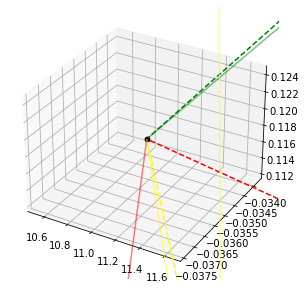

In [1381]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(projection='3d')

# plot_B(ax,B1)
plot_B(ax,B2,ls='--')
plot_B(ax,B1_new,alpha=0.5)
# plot_B(ax,np.vstack((np.array(b1[0]),b1)),ls='--')
# # plot_B(ax,np.vstack((np.array(b1[0]),b1_new)),alpha=0.5)


In [1141]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D




r.as_euler('xyz')



array([-0.18373569, -0.07766086,  0.20328443])

In [305]:
(B1[3],B2[3])

RB1 = B1[0]
RB2 = B2[0]
BN = B1[3]

In [306]:
rise = np.dot((RB2 - RB1),BN)
rise

-1.5

In [ ]:
rotation axis Ue
translation labmda_e
rotationmatrix_Re
OU*D
OU*L
OU*N
U toration axis
O angle through axis
tilt, roll and twist

In [ ]:
#origin/point Om or BR
# and orthogonal vectors 
#BL vector pointing towards the phosphodiester backbone joined to the base (x)
#BD vector pointing towards the major groove (y)
#BN normal to the mean plane of the base (z)



In [134]:
A = md.load('./atomic/BDNA_A.pdb')
T = md.load('./atomic/BDNA_T.pdb')
G = md.load('./atomic/BDNA_G.pdb')
C = md.load('./atomic/BDNA_C.pdb')

T.xyz = -T.xyz
AT = A.stack(T)

In [135]:
view = nv.show_mdtraj(AT)
view.clear()
view.add_representation('ball+stick')
view

NGLWidget()

In [137]:
def create_basis(basepair):
    
    basepair.atom_slice = 
    reate your initial basis by:

    Computing the vectors: x=(b-a) and y=(c-a)
    Normalize x (x = x / magnitude(x))
    Project y onto x (proj_y = x DOT y * x)
    Subtract the projection from y (y = y - proj_y)
    Normalize y
    Compute z = x CROSS y


[A1-P,
 A1-OP1,
 A1-OP2,
 A1-O5',
 A1-C5',
 A1-C4',
 A1-O4',
 A1-C3',
 A1-O3',
 A1-C2',
 A1-C1',
 A1-N9,
 A1-C8,
 A1-N7,
 A1-C5,
 A1-C6,
 A1-N6,
 A1-N1,
 A1-C2,
 A1-N3,
 A1-C4,
 T1-P,
 T1-O1P,
 T1-O2P,
 T1-O5',
 T1-C5',
 T1-C4',
 T1-O4',
 T1-C3',
 T1-O3',
 T1-C2',
 T1-C1',
 T1-N1,
 T1-C2,
 T1-O2,
 T1-N3,
 T1-C4,
 T1-O4,
 T1-C5,
 T1-C5M,
 T1-C6]

# Generate Curves

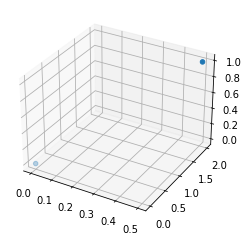

In [120]:
points = np.array([[0,0,0],[0,1,1],[-1,1,2]])
points = np.array([[0,0,0],[0.5,2,1]])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:, 0],points[:, 1],points[:, 2])

In [98]:
# turn box in voxels that are either occupied or not occupied
# define beginning and end points 
# fit bezier around occupied voxels or find shortest path A*/dijkstra through empty voxels